<a href="https://colab.research.google.com/github/BelalMJ/BelalMJ_64061/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BA64061 - Assignment 4: Text and Sequence Data

Setup and Data Preparation

In [ ]:
import numpy as np  # Numerical computing
import tensorflow as tf # Deep learning framework
from tensorflow import keras  # High-level neural networks API
from tensorflow.keras import layers # Keras layer implementations
import matplotlib.pyplot as plt # Data visualization
import pandas as pd # Data manipulation and analysis
from tqdm.keras import TqdmCallback # Progress bar for training

# Configuration parameters for our experiment
num_words = 10000
maxlen = 150
training_samples = 100
validation_samples = 10000
batch_size = 32
epochs = 20  # Increased for meaningful learning curves

# Load and split data (IMDB movie review dataset)
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)

# Create training, validation, and test splits
x_train = x_train_full[:training_samples]
y_train = y_train_full[:training_samples]
x_val = x_train_full[training_samples:training_samples+validation_samples]
y_val = y_train_full[training_samples:training_samples+validation_samples]

# Pad sequences to ensure uniform length (150 words)
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

# Print dataset shapes for verification
print(f"Training data: {x_train.shape}, Validation: {x_val.shape}, Test: {x_test.shape}")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data: (100, 150), Validation: (10000, 150), Test: (25000, 150)


Evaluation Utilities

In [ ]:
# Function to evaluate model performance across train/val/test sets
def evaluate_model(model, name, x_train, y_train, x_val, y_val, x_test, y_test):
    train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    return {
        'Model': name,
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Test Accuracy': test_acc,
        'Train Loss': train_loss,
        'Validation Loss': val_loss,
        'Test Loss': test_loss
    }

# Function to plot training accuracy across epochs
def plot_training_accuracy(histories, sample_size, model_names):
    plt.figure(figsize=(8, 5))

    for name, history in zip(model_names, histories):
        plt.plot(history.history['accuracy'], label=f'{name}')

    plt.title(f'Training Accuracy (Samples={sample_size})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to compare model performance across different sample sizes
def plot_sample_size_comparison(results_df, metric='Accuracy'):
    plt.figure(figsize=(12, 6))

    models = results_df['Model'].unique()
    sample_sizes = results_df['Training Samples'].unique()

    # Plot performance curve for each model
    for model in models:
        subset = results_df[results_df['Model'] == model]
        plt.plot(subset['Training Samples'], subset[f'Test {metric}'], 'o-', label=model)

    plt.title(f'Test {metric} vs Training Samples')
    plt.xlabel('Training Samples')
    plt.ylabel(f'Test {metric}')
    plt.xscale('log')
    plt.xticks(sample_sizes, labels=sample_sizes)
    plt.legend()
    plt.grid(True)
    plt.show()

Applying RNN with Learned Embeddings

In [ ]:
# Create sequential model with multiple layers
def build_rnn_learned():
    model = keras.Sequential([
        layers.Embedding(input_dim=num_words, output_dim=128, input_length=maxlen),
        layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True),
        layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])


# Compile model with Adam optimizer and binary crossentropy loss
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

# Early stopping callback to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

# Build and train the RNN with learned embeddings
model_rnn_learned = build_rnn_learned()
history_rnn_learned = model_rnn_learned.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, TqdmCallback(verbose=0)],
    verbose=0)

# Evaluate model performance
rnn_learned_metrics = evaluate_model(
    model_rnn_learned, "RNN Learned",
    x_train, y_train, x_val, y_val, x_test, y_test)

0epoch [00:00, ?epoch/s]

Applying RNN with Pretrained GloVe Embeddings

In [ ]:
# Download and prepare GloVe embeddings
!rm -f glove.6B.zip  # Remove any broken version
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

embedding_dim = 100
embedding_index = {}

# Parse the GloVe file and create word-to-vector mapping
with open("glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Get IMDB dataset's word index mapping
word_index = keras.datasets.imdb.get_word_index()
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Create model similar to learned RNN but with GloVe embeddings
def build_rnn_glove():
    model = keras.Sequential([
        layers.Embedding(input_dim=num_words, output_dim=embedding_dim,
                       input_length=maxlen, weights=[embedding_matrix],
                       trainable=True),  # Now trainable for fine-tuning
        layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True),
        layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

# Use lower learning rate for fine-tuning pre-trained embeddings
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # Lower LR for fine-tuning
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

# Build and train the GloVe-enhanced RNN
model_rnn_glove = build_rnn_glove()
history_rnn_glove = model_rnn_glove.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, TqdmCallback(verbose=0)],
    verbose=0)

# Evaluate GloVe model performance
rnn_glove_metrics = evaluate_model(
    model_rnn_glove, "RNN GloVe",
    x_train, y_train, x_val, y_val, x_test, y_test)

--2025-04-14 05:00:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-14 05:00:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-14 05:00:46--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

0epoch [00:00, ?epoch/s]

Applying Transformer Model

In [ ]:
# Custom Transformer block implementation
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Positional embedding layer to add sequence position information
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_emb(inputs)
        embedded_positions = self.pos_emb(positions)
        return embedded_tokens + embedded_positions

# Define transformer architecture parameters
def build_transformer():
    embed_dim = 64  # Increased from 32
    num_heads = 4
    ff_dim = 128    # Increased from 64

# Model inputs (sequence of word indices)
    inputs = keras.Input(shape=(maxlen,))
    x = PositionalEmbedding(maxlen, num_words, embed_dim)(inputs)
    x = layers.Dropout(0.2)(x)

    # Stack two transformer blocks
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    # Pooling and classification layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)

    # Compile with Adam optimizer
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

# Build and train the Transformer model
model_transformer = build_transformer()
history_transformer = model_transformer.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, TqdmCallback(verbose=0)],
    verbose=0)

# Evaluate Transformer performance
transformer_metrics = evaluate_model(
    model_transformer, "Transformer",
    x_train, y_train, x_val, y_val, x_test, y_test)

0epoch [00:00, ?epoch/s]

Initial Comparison with 100 Samples

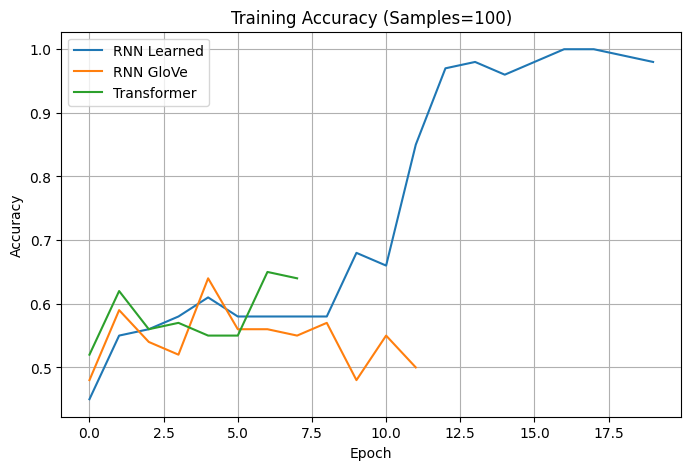


=== Performance Comparison (100 Samples) ===


,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Train Loss,Validation Loss,Test Loss
0,RNN Learned,100.00%,63.70%,63.10%,0.3597,0.8570,0.8571
1,RNN GloVe,58.00%,49.48%,50.00%,0.9954,1.0085,1.0079
2,Transformer,61.00%,50.82%,51.06%,1.0902,1.1339,1.1319


In [ ]:
# Plot training accuracy for all models
plot_training_accuracy(
    [history_rnn_learned, history_rnn_glove, history_transformer],
    sample_size=100,
    model_names=["RNN Learned", "RNN GloVe", "Transformer"]
)

# Create comparison table
results_df = pd.DataFrame([rnn_learned_metrics, rnn_glove_metrics, transformer_metrics])

# Store these results for later use in the next cell
initial_results = results_df.copy()
initial_results['Training Samples'] = 100

# Display formatted results
formatted_df = results_df.copy()
for col in ['Train Accuracy', 'Validation Accuracy', 'Test Accuracy']:
    formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.2%}")
for col in ['Train Loss', 'Validation Loss', 'Test Loss']:
    formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.4f}")

print("\n=== Performance Comparison (100 Samples) ===")
display(formatted_df)

Comprehensive Sample Size Experiments (include 100 samples without retraining)

In [ ]:
sample_sizes = [100, 500, 1000, 5000, 25000 ]  # Now includes 100 for plotting
all_histories = []
experiment_results = []

# Add our initial 100-sample results
experiment_results.extend(initial_results.to_dict('records'))

# Only train on larger sample sizes
for size in [s for s in sample_sizes if s != 100]:
    print(f"\n=== Training with {size} samples ===")
    x_train_sub = x_train_full[:size]
    y_train_sub = y_train_full[:size]
    x_train_sub = keras.preprocessing.sequence.pad_sequences(x_train_sub, maxlen=maxlen)

    # Build fresh models for each experiment
    models = {
        "RNN Learned": build_rnn_learned(),
        "RNN GloVe": build_rnn_glove(),
        "Transformer": build_transformer()
    }

    size_histories = []
    for name, model in models.items():
        print(f"Training {name}...")
        history = model.fit(
            x_train_sub, y_train_sub,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
            callbacks=[early_stopping, TqdmCallback(verbose=0)],
            verbose=0
        )
        size_histories.append(history)

        metrics = evaluate_model(
            model, name,
            x_train_sub, y_train_sub,
            x_val, y_val,
            x_test, y_test)
        metrics['Training Samples'] = size
        experiment_results.append(metrics)

    all_histories.append((size, size_histories))

# Create comprehensive results dataframe
exp_df = pd.DataFrame(experiment_results)

Comparison table and plots


=== Training with 500 samples ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training RNN Learned...


0epoch [00:00, ?epoch/s]

Training RNN GloVe...


0epoch [00:00, ?epoch/s]

Training Transformer...


0epoch [00:00, ?epoch/s]


=== Training with 1000 samples ===
Training RNN Learned...


0epoch [00:00, ?epoch/s]

Training RNN GloVe...


0epoch [00:00, ?epoch/s]

Training Transformer...


0epoch [00:00, ?epoch/s]


=== Training with 5000 samples ===
Training RNN Learned...


0epoch [00:00, ?epoch/s]

Training RNN GloVe...


0epoch [00:00, ?epoch/s]

Training Transformer...


0epoch [00:00, ?epoch/s]


=== Training with 25000 samples ===
Training RNN Learned...


0epoch [00:00, ?epoch/s]

Training RNN GloVe...


0epoch [00:00, ?epoch/s]

Training Transformer...


0epoch [00:00, ?epoch/s]

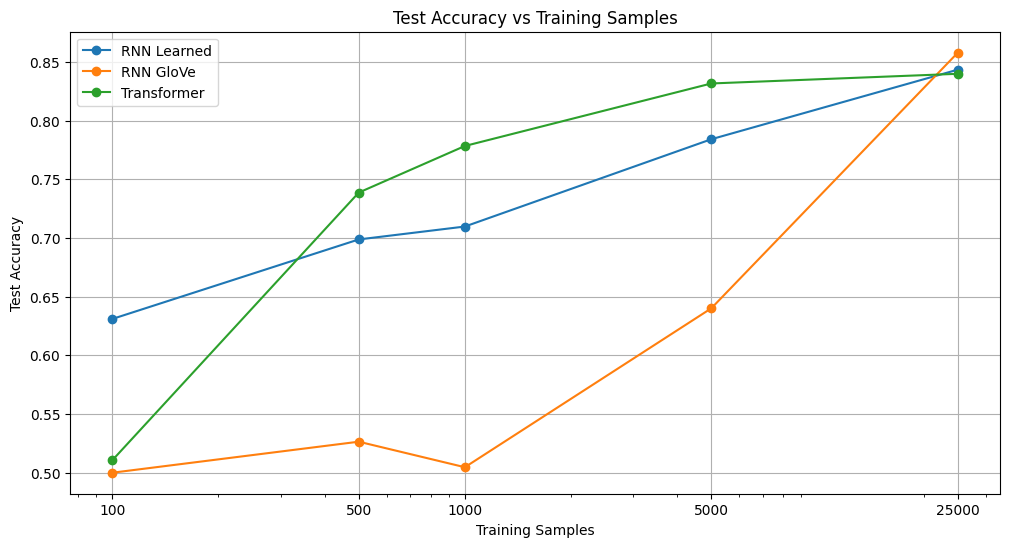


=== Final Comprehensive Results ===


,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Train Loss,Validation Loss,Test Loss,Training Samples
1,RNN GloVe,58.00%,49.48%,50.00%,0.9954,1.0085,1.0079,100
0,RNN Learned,100.00%,63.70%,63.10%,0.3597,0.8570,0.8571,100
2,Transformer,61.00%,50.82%,51.06%,1.0902,1.1339,1.1319,100
4,RNN GloVe,55.00%,52.63%,52.64%,0.9406,0.9419,0.9416,500
3,RNN Learned,95.20%,70.56%,69.88%,0.4037,0.7347,0.7440,500
5,Transformer,97.60%,74.87%,73.87%,0.5185,0.8668,0.8810,500
7,RNN GloVe,51.60%,49.93%,50.46%,0.8936,0.8962,0.8959,1000
6,RNN Learned,92.20%,72.04%,70.98%,0.4356,0.6912,0.7076,1000
8,Transformer,98.10%,79.42%,77.84%,0.4546,0.8219,0.8498,1000
10,RNN GloVe,69.06%,66.75%,64.01%,0.6563,0.6643,0.6733,5000


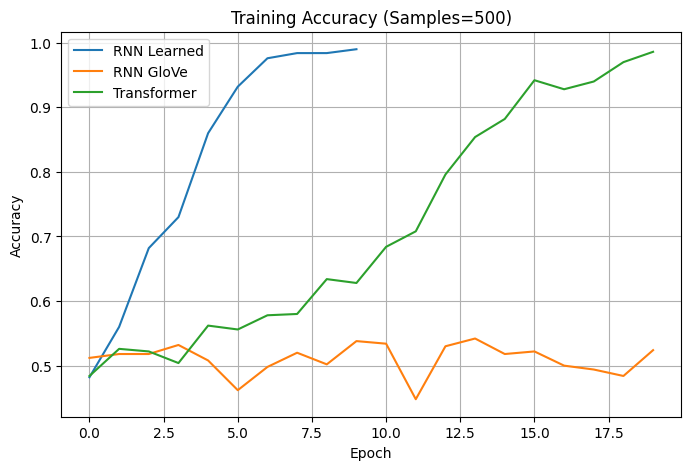

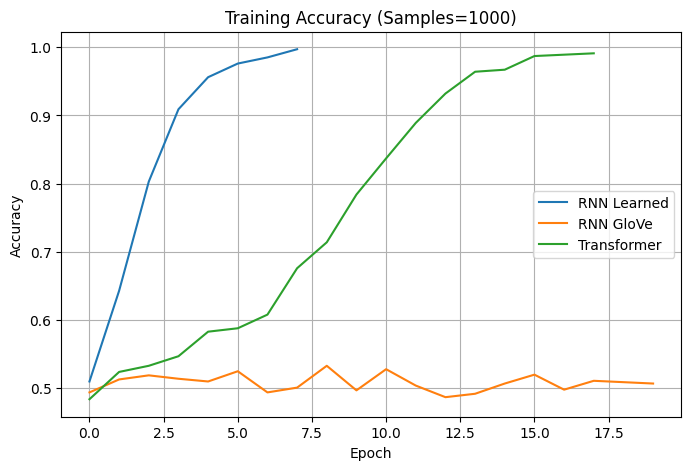

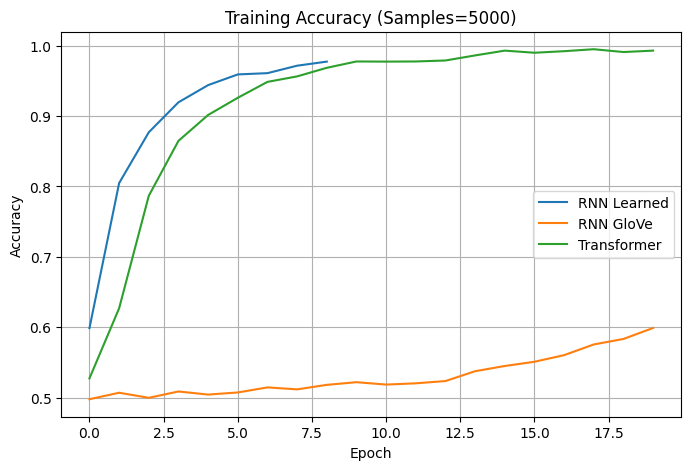

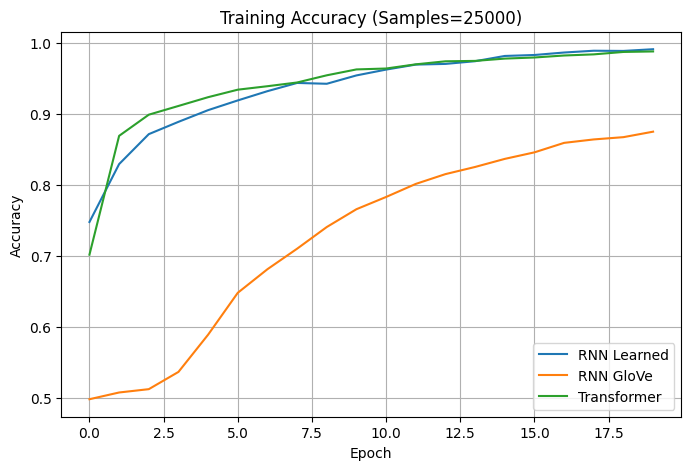

In [ ]:
# Plot sample size comparison
plot_sample_size_comparison(exp_df, metric='Accuracy')

# Create final results table with all metrics
final_results = exp_df.copy()
for col in ['Train Accuracy', 'Validation Accuracy', 'Test Accuracy']:
    final_results[col] = final_results[col].apply(lambda x: f"{x:.2%}")
for col in ['Train Loss', 'Validation Loss', 'Test Loss']:
    final_results[col] = final_results[col].apply(lambda x: f"{x:.4f}")

print("\n=== Final Comprehensive Results ===")
display(final_results.sort_values(['Training Samples', 'Model']))

# Plot training accuracy for each sample size (except 100 which we already plotted)
for size, histories in all_histories:
    plot_training_accuracy(
        histories,
        sample_size=size,
        model_names=["RNN Learned", "RNN GloVe", "Transformer"]
    )

In [ ]:
!jupyter nbconvert --to notebook --ClearMetadataPreprocessor.enabled=True your_notebook.ipynb

[NbConvertApp] WARNING | pattern 'your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 